In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/Alcohol_Sales.csv', index_col='DATE', parse_dates=True)
df.index.freq = 'MS'

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [4]:
df.columns = ['sales']

<Axes: xlabel='DATE'>

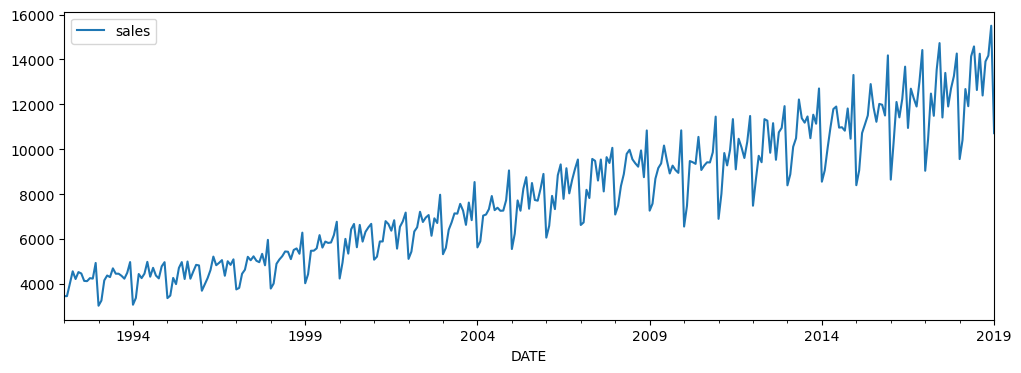

In [5]:
df.plot(figsize = (12, 4))

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
res = seasonal_decompose(df['sales'])

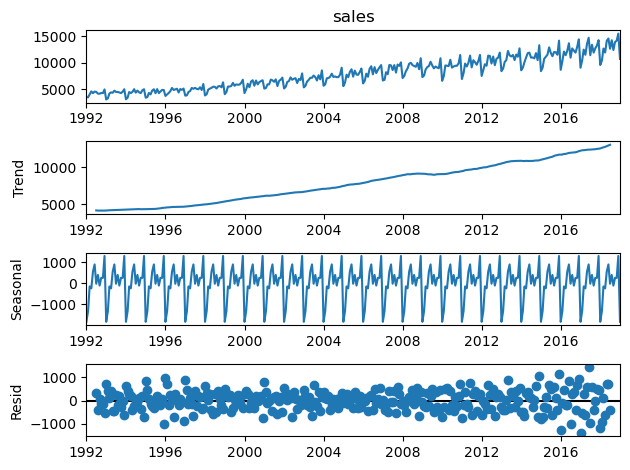

In [8]:
res.plot();

<Axes: xlabel='DATE'>

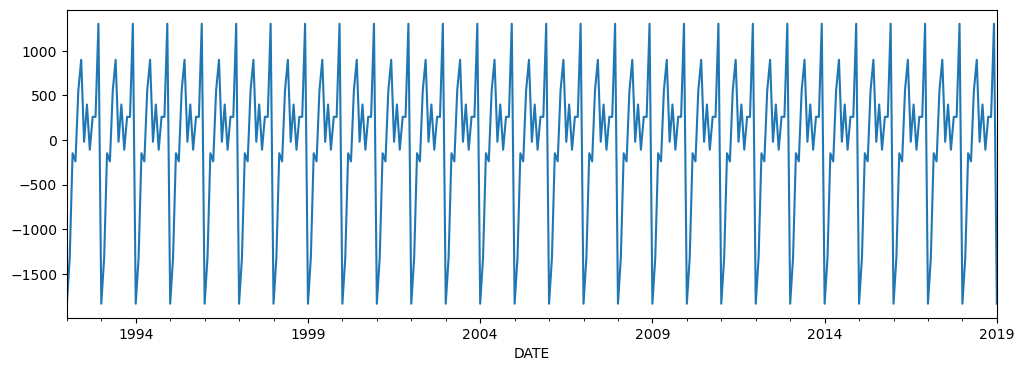

In [9]:
res.seasonal.plot(figsize = (12, 4))

### Train Test Split

In [10]:
train = df[:-12]
test = df[-12:]

In [11]:
test

,sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train)   # fit only on training data

MinMaxScaler()

In [15]:
sc_train = scaler.transform(train)
sc_test = scaler.transform(test)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [29]:
'''
This problem is similar to predicting the next word in text generation, therefore, the input and the labels i.e. the target
are contained in the same attribute, in this case it's sales. For this example, we will use two datapoints to predict the
next value.
'''

# for data with seasonality, the seasonal window value works best, as this is monthly data with yearly seasonality
seq_length = 12    
n_feat = 1

generator = TimeseriesGenerator(data=sc_train, targets=sc_train, length=seq_length, batch_size=1)

In [30]:
len(sc_train)

313

In [31]:
len(generator)

301

In [32]:
X, y = generator[0]
print(f'X = {X}')
print(f'y = {y}')

X = [[[0.03658432]
  [0.03649885]
  [0.08299855]
  [0.13103684]
  [0.1017181 ]
  [0.12804513]
  [0.12266006]
  [0.09453799]
  [0.09359774]
  [0.10496624]
  [0.10334217]
  [0.16283443]]]
y = [[0.]]


In [33]:
X, y = generator[1]
print(f'X = {X}')
print(f'y = {y}')

X = [[[0.03649885]
  [0.08299855]
  [0.13103684]
  [0.1017181 ]
  [0.12804513]
  [0.12266006]
  [0.09453799]
  [0.09359774]
  [0.10496624]
  [0.10334217]
  [0.16283443]
  [0.        ]]]
y = [[0.0196598]]


In [34]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [38]:
model = Sequential()

model.add(LSTM(150, activation = 'relu', input_shape = (seq_length, n_feat)))
model.add(Dense(1))
model.compile(optimizer ='adam', loss = 'mse')

In [39]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [40]:
model.fit_generator(generator, epochs = 25)

C:\Users\shisk\AppData\Local\Temp\ipykernel_3516\2867228025.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs = 25)


Epoch 1/25
301/301 [==============================] - 5s 9ms/step - loss: 0.0154
Epoch 2/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0101
Epoch 3/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0088
Epoch 4/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0078
Epoch 5/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0079
Epoch 6/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0057
Epoch 7/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0045
Epoch 8/25
301/301 [==============================] - 3s 9ms/step - loss: 0.0028
Epoch 9/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0026
Epoch 10/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0025
Epoch 11/25
301/301 [==============================] - 3s 11ms/step - loss: 0.0024
Epoch 12/25
301/301 [==============================] - 3s 10ms/step - loss: 0.0022
Epoch 13/25
301/301 [

In [48]:
loss = model.history.history['loss']

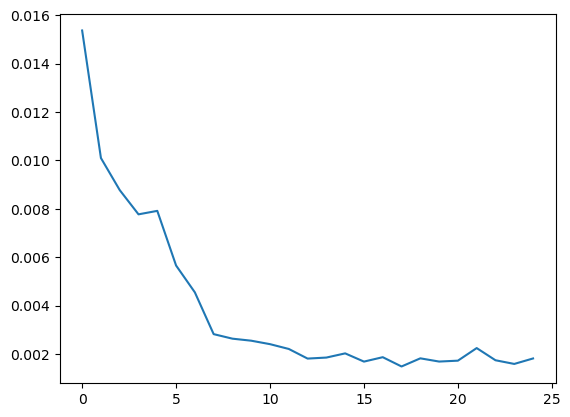

In [49]:
plt.plot(loss)

### Evaluation on Test Data

In [51]:
# last 12 datapoints of the training data --> 1st of th test data
first_eval_batch = sc_train[-12:]

In [52]:
first_eval_batch = first_eval_batch.reshape((1, seq_length, n_feat))

In [55]:
first_eval_batch.shape

(1, 12, 1)

In [53]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 290ms/step


array([[0.7373176]], dtype=float32)

In [54]:
sc_test[0]

array([0.63116506])

### Forecasting

In [57]:
# holding predictions
test_pred = []

# last n points from the training set will be used to start the prediction
first_eval_batch = sc_train[-seq_length:]
current_batch = first_eval_batch.reshape((1, seq_length, n_feat))

# set number of predictions to make
no_of_pred = 12

# the predicted datapoint will be added to the evaluation data to predict the next point
for i in range(no_of_pred):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    
    # the datapoints are in axis = 1 i.e. the second axis so we append there
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis = 1)

1/1 [==============================] - 0s 43ms/step


In [68]:
test_pred = np.array(test_pred)

array([[0.7373176 ],
       [0.80574733],
       [0.8136899 ],
       [0.9395128 ],
       [0.9806623 ],
       [0.799448  ],
       [0.8877849 ],
       [0.7890793 ],
       [0.8586595 ],
       [0.9050989 ],
       [0.94443   ],
       [0.6583699 ]], dtype=float32)

### Plot Predictions

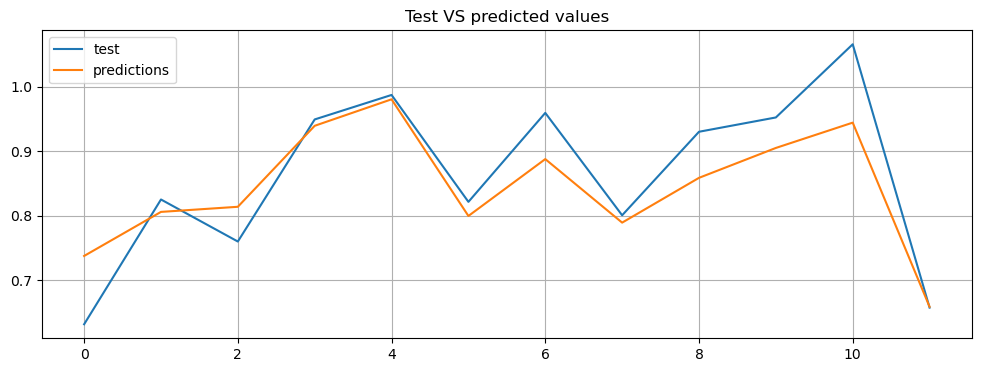

In [78]:
plt.figure(figsize = (12, 4))
plt.title('Test VS predicted values')
plt.plot(sc_test)
plt.plot(test_pred)
plt.grid()
plt.legend(['test', 'predictions'])